## Generating the Evolutionary Probabilty-based Encoding

In order to encode the sequences, the fasta file, the starting position (index of first residue of sequence), the paramter (output) file of the program 'PLMC', and the CSV file containing the variants name and their associated measured fitness have to be provided (see example file 'rl401_files/RL401_YEAST_Bolon2013.csv').

## Low-N

In [1]:
dataset='rl401_files/RL401_YEAST_Bolon2013'
n_cores=6

import numpy as np
import multiprocessing as mp
from scripts.hybrid_model import Hybrid_Model

study=Hybrid_Model('%s_wt_encoded.npy'%(dataset),'%s_encoded.csv'%(dataset))

train_sizes_shuffled=study._get_train_sizes()
np.random.shuffle(train_sizes_shuffled)

if train_sizes_shuffled.size < n_cores:
    n_cores=train_sizes_shuffled.size

manager=mp.Manager()
data=manager.list()

processes=[]
for train_sizes in np.array_split(train_sizes_shuffled,n_cores):
    p=mp.Process(target=study.run, args=[train_sizes,data])
    p.start()
    processes.append(p)

for p in processes:
    p.join()

data=np.array(data,dtype=object)
data=np.concatenate(data,axis=1)
np.save('%s_hybrid_model_data.npy'%(dataset),data)

## Visualize Results

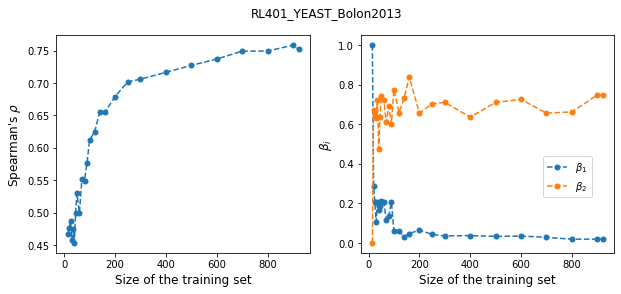

In [3]:
import matplotlib.pyplot as plt

def sort_and_analyze(
    x:np.ndarray,
    arg:np.ndarray,
    n_runs=10
    ) -> np.ndarray:

    x=x[arg]
    x=np.split(x,int(x.size/n_runs))
    x=np.vstack(x)    
    return np.mean(x,axis=1)

data=np.load('%s_hybrid_model_data.npy'%(dataset),allow_pickle=True)
spearmanrs,_,betas_1,betas_2,training_sizes,_=data # spearmanrs, alphas, betas_1, betas_2, training_sizes, testing_sizes
arg=np.argsort(training_sizes)
x_training=sort_and_analyze(training_sizes,arg)
spearmanrs_mean=sort_and_analyze(spearmanrs,arg)
betas_1=sort_and_analyze(betas_1,arg)
betas_2=sort_and_analyze(betas_2,arg)

fig,axes=plt.subplots(1,2,figsize=(10,4))
axes[0].plot(x_training,spearmanrs_mean,marker='o',markersize=5,linestyle='--')
axes[0].set_xlabel('Size of the training set',size=12)
axes[0].set_ylabel(r"Spearman's $\rho$",size=12)
axes[1].plot(x_training,betas_1,marker='o',markersize=5,linestyle='--',label=r'$\beta_1$')
axes[1].plot(x_training,betas_2,marker='o',markersize=5,linestyle='--',label=r'$\beta_2$')
axes[1].set_xlabel('Size of the training set',size=12)
axes[1].set_ylabel(r'$\beta_{i}$',size=12)
axes[1].legend(bbox_to_anchor=[0.7,0.35],loc='center left')
fig.suptitle('RL401_YEAST_Bolon2013')
plt.show()